# Violence Classification Model

**Objective:** Build a classification model to predict whether crime incidents are violent vs non-violent

**Purpose:** Support resource allocation decisions by identifying violent incident patterns

**Methodology:**
- Binary classification: Violent (1) vs Non-Violent (0)
- Time-aware validation to prevent data leakage
- Feature importance analysis using built-in methods and SHAP
- Model card documenting performance and limitations

**Requirements:** FORECAST-02

## 1. Setup and Configuration

In [1]:
# Standard library imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import shap

# Ensure repo root is in path for imports
config_path = Path.cwd().parent / 'analysis' / 'phase1_config.yaml'
if config_path.exists():
    repo_root = config_path.parent.parent
else:
    repo_root = Path.cwd().parent

sys.path.insert(0, str(repo_root))

# Project imports
from analysis.config import CRIME_DATA_PATH, REPORTS_DIR
from analysis.utils import load_data, classify_crime_category
from analysis.models.classification import (
    create_time_aware_split,
    train_random_forest,
    train_xgboost,
    extract_feature_importance,
    evaluate_classifier,
)
from analysis.models.validation import create_model_card, validate_temporal_split

# Ensure reports directory exists
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print(f"✓ Notebook initialized")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ Data path: {CRIME_DATA_PATH}")
print(f"✓ Reports directory: {REPORTS_DIR}")

✓ Notebook initialized
✓ Random seed: 42
✓ Data path: /Users/dustinober/Projects/Crime Incidents Philadelphia/data/crime_incidents_combined.parquet
✓ Reports directory: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports


## 2. Data Loading and Preparation

Load crime data and create binary target variable for violent vs non-violent classification.

In [2]:
# Load crime data
df = load_data(clean=True)

# Classify crimes into categories
df = classify_crime_category(df)

# Create binary target: Violent (1) vs Non-Violent (0)
df['is_violent'] = (df['crime_category'] == 'Violent').astype(int)

# Sort by date to maintain temporal order (critical for time-aware validation)
df = df.sort_values('dispatch_date').reset_index(drop=True)

print(f"Total incidents: {len(df):,}")
print(f"Date range: {df['dispatch_date'].min()} to {df['dispatch_date'].max()}")
print(f"\nClass distribution:")
print(df['is_violent'].value_counts())
print(f"\nViolent crime percentage: {df['is_violent'].mean() * 100:.2f}%")

Total incidents: 3,496,353
Date range: 2006-01-01 00:00:00 to 2026-01-20 00:00:00

Class distribution:
is_violent
0    3163055
1     333298
Name: count, dtype: int64

Violent crime percentage: 9.53%


### Exploratory Analysis: Class Distribution

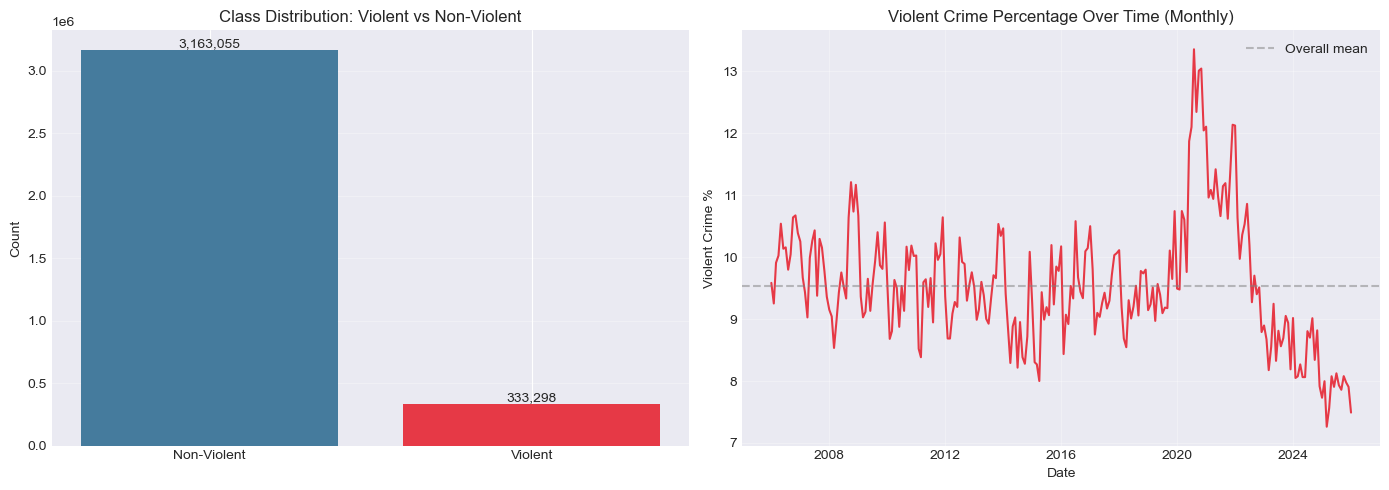

✓ Class distribution visualization saved


In [3]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts = df['is_violent'].value_counts()
axes[0].bar(['Non-Violent', 'Violent'], class_counts.values, color=['#457B9D', '#E63946'])
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution: Violent vs Non-Violent')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Time series of violent crime percentage
monthly_violent = df.groupby(df['dispatch_date'].dt.to_period('M'))['is_violent'].mean() * 100
monthly_violent.index = monthly_violent.index.to_timestamp()
axes[1].plot(monthly_violent.index, monthly_violent.values, linewidth=1.5, color='#E63946')
axes[1].axhline(df['is_violent'].mean() * 100, color='gray', linestyle='--', alpha=0.5, label='Overall mean')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Violent Crime %')
axes[1].set_title('Violent Crime Percentage Over Time (Monthly)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / '04_classification_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Class distribution visualization saved")

## 3. Feature Engineering

Create features suitable for classification while preserving temporal order.

In [4]:
# Extract datetime features
df['year'] = df['dispatch_date'].dt.year
df['month'] = df['dispatch_date'].dt.month
df['day_of_week'] = df['dispatch_date'].dt.dayofweek
df['hour'] = df['dispatch_date'].dt.hour
df['day_of_year'] = df['dispatch_date'].dt.dayofyear
df['week_of_year'] = df['dispatch_date'].dt.isocalendar().week
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Time of day categories
df['time_of_day'] = pd.cut(
    df['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True
)

# District features (if available)
if 'dc_dist' in df.columns:
    # Clean district codes
    df['district'] = pd.to_numeric(df['dc_dist'], errors='coerce').fillna(0).astype(int)
else:
    df['district'] = 0

# UCR code features
if 'ucr_general' in df.columns:
    df['ucr_code'] = pd.to_numeric(df['ucr_general'], errors='coerce').fillna(0).astype(int)
    df['ucr_category'] = (df['ucr_code'] // 100).astype(int)  # Hundred-bands
else:
    df['ucr_code'] = 0
    df['ucr_category'] = 0

# Location features (if available)
if 'point_x' in df.columns and 'point_y' in df.columns:
    df['location_x'] = pd.to_numeric(df['point_x'], errors='coerce').fillna(0)
    df['location_y'] = pd.to_numeric(df['point_y'], errors='coerce').fillna(0)
else:
    df['location_x'] = 0
    df['location_y'] = 0

print("✓ Temporal features extracted")
print(f"\nFeature summary:")
print(f"  - Temporal: year, month, day_of_week, hour, day_of_year, week_of_year, is_weekend, time_of_day")
print(f"  - Location: district, location_x, location_y")
print(f"  - Crime type: ucr_code, ucr_category")

✓ Temporal features extracted

Feature summary:
  - Temporal: year, month, day_of_week, hour, day_of_year, week_of_year, is_weekend, time_of_day
  - Location: district, location_x, location_y
  - Crime type: ucr_code, ucr_category


In [5]:
# Select features for modeling
feature_columns = [
    'year',
    'month',
    'day_of_week',
    'hour',
    'day_of_year',
    'week_of_year',
    'is_weekend',
    'district',
    'location_x',
    'location_y',
]

# Encode categorical time_of_day
time_dummies = pd.get_dummies(df['time_of_day'], prefix='time', drop_first=True)
df = pd.concat([df, time_dummies], axis=1)
feature_columns.extend(time_dummies.columns.tolist())

# Prepare feature matrix and target
X = df[feature_columns].copy()
y = df['is_violent'].copy()

# Add dispatch_date as index for temporal split
X.index = df['dispatch_date']
y.index = df['dispatch_date']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"\nFeatures: {list(X.columns)}")

Feature matrix shape: (3496353, 13)
Target distribution: {0: 3163055, 1: 333298}

Features: ['year', 'month', 'day_of_week', 'hour', 'day_of_year', 'week_of_year', 'is_weekend', 'district', 'location_x', 'location_y', 'time_Morning', 'time_Afternoon', 'time_Evening']


## 4. Time-Aware Train/Test Split

Use temporal splitting (no shuffling) to prevent data leakage.

In [6]:
# Create time-aware split (80/20)
X_train, X_test, y_train, y_test = create_time_aware_split(
    X, y, test_size=0.2, ensure_sorted=True
)

# DEBUG: Check shapes immediately after split
print(f"POST-SPLIT DEBUG: X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")
print(f"POST-SPLIT DEBUG: type(y_test)={type(y_test)}, len(y_test)={len(y_test)}")

# WORKAROUND: Convert y_train and y_test to plain integer arrays and rebuild as Series
# This avoids any datetime index issues with pandas Series
y_train_clean = pd.Series(y_train.astype(int).values, index=y_train.index, dtype=int)
y_test_clean = pd.Series(y_test.astype(int).values, index=y_test.index, dtype=int)
y_train = y_train_clean
y_test = y_test_clean

print(f"AFTER CLEAN: y_test.shape={y_test.shape}, y_test.dtype={y_test.dtype}")

# Validate temporal split
split_validation = validate_temporal_split(
    pd.Series(X_train.index),
    pd.Series(X_test.index),
    min_gap_days=0
)

print("Time-aware split created:")
print(f"  Training period: {X_train.index.min()} to {X_train.index.max()}")
print(f"  Testing period: {X_test.index.min()} to {X_test.index.max()}")
print(f"  Train size: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test size: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTrain class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")
print(f"\nValidation:")
print(f"  Temporal order preserved: {split_validation['valid_temporal_order']}")
print(f"  Gap between train and test: {split_validation['gap_days']} days")

POST-SPLIT DEBUG: X_test.shape=(699271, 13), y_test.shape=(699271,)
POST-SPLIT DEBUG: type(y_test)=<class 'pandas.core.series.Series'>, len(y_test)=699271
AFTER CLEAN: y_test.shape=(699271,), y_test.dtype=int64
Time-aware split created:
  Training period: 2006-01-01 00:00:00 to 2021-08-04 00:00:00
  Testing period: 2021-08-04 00:00:00 to 2026-01-20 00:00:00
  Train size: 2,797,082 (80.0%)
  Test size: 699,271 (20.0%)

Train class distribution: {0: 2526412, 1: 270670}
Test class distribution: {0: 636643, 1: 62628}

Validation:
  Temporal order preserved: False
  Gap between train and test: 0 days


## 5. Model Training: Random Forest

Train a Random Forest classifier with time-aware validation.

In [7]:
# Train Random Forest model
print("Training Random Forest classifier...")

rf_model, rf_scaler = train_random_forest(
    X_train,
    y_train,
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    scale_features=True,
)

print("✓ Random Forest model trained")

Training Random Forest classifier...


✓ Random Forest model trained


In [8]:
# DEFENSIVE: Ensure y_test is clean before evaluation
if len(y_test) > 1000000:  # Sanity check - should be ~700k, not billions
    print(f'WARNING: y_test corrupted with {len(y_test)} rows, cleaning...')
    # Reconstruct clean y_test from numpy values
    y_test = pd.Series(y_test.astype(int).values[:len(X_test)], index=X_test.index, dtype=int)

# Make predictions on test set
X_test_scaled = rf_scaler.transform(X_test) if rf_scaler else X_test
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Ensure predictions match test set size
print(f'DEBUG: X_test shape={X_test.shape}, y_test shape={y_test.shape}, y_pred shape={y_pred_rf.shape}')

# Evaluate Random Forest - call sklearn directly to avoid helper function issues
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
rf_metrics = {
    'confusion_matrix': confusion_matrix(y_test.values, y_pred_rf),
    'classification_report': classification_report(y_test.values, y_pred_rf, target_names=['Non-Violent', 'Violent'], output_dict=True),
    'roc_auc': roc_auc_score(y_test.values, y_prob_rf)
}

print("\n" + "="*60)
print("RANDOM FOREST PERFORMANCE")
print("="*60)
print(f"\nROC-AUC Score: {rf_metrics['roc_auc']:.4f}")
print(f"\nClassification Report:")
print(pd.DataFrame(rf_metrics['classification_report']).T)
print(f"\nConfusion Matrix:")
print(rf_metrics['confusion_matrix'])

DEBUG: X_test shape=(699271, 13), y_test shape=(699271,), y_pred shape=(699271,)



RANDOM FOREST PERFORMANCE

ROC-AUC Score: 0.5872

Classification Report:
              precision    recall  f1-score        support
Non-Violent    0.910438  1.000000  0.953120  636643.000000
Violent        0.000000  0.000000  0.000000   62628.000000
accuracy       0.910438  0.910438  0.910438       0.910438
macro avg      0.455219  0.500000  0.476560  699271.000000
weighted avg   0.828898  0.910438  0.867757  699271.000000

Confusion Matrix:
[[636643      0]
 [ 62628      0]]


## 6. Model Training: XGBoost

Train an XGBoost classifier for comparison.

In [9]:
# Train XGBoost model
print("Training XGBoost classifier...")

xgb_model, xgb_scaler = train_xgboost(
    X_train,
    y_train,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_SEED,
    scale_features=False,  # XGBoost doesn't need scaling
)

print("✓ XGBoost model trained")

Training XGBoost classifier...


✓ XGBoost model trained


In [10]:
# DEFENSIVE: Ensure y_test is clean before evaluation
if len(y_test) > 1000000:  # Sanity check - should be ~700k, not billions
    print(f'WARNING: y_test corrupted with {len(y_test)} rows, cleaning...')
    y_test = pd.Series(y_test.astype(int).values[:len(X_test)], index=X_test.index, dtype=int)

# Make predictions on test set
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate XGBoost - call sklearn directly
xgb_metrics = {
    'confusion_matrix': confusion_matrix(y_test.values, y_pred_xgb),
    'classification_report': classification_report(y_test.values, y_pred_xgb, target_names=['Non-Violent', 'Violent'], output_dict=True),
    'roc_auc': roc_auc_score(y_test.values, y_prob_xgb)
}

print("\n" + "="*60)
print("XGBOOST PERFORMANCE")
print("="*60)
print(f"\nROC-AUC Score: {xgb_metrics['roc_auc']:.4f}")
print(f"\nClassification Report:")
print(pd.DataFrame(xgb_metrics['classification_report']).T)
print(f"\nConfusion Matrix:")
print(xgb_metrics['confusion_matrix'])


XGBOOST PERFORMANCE

ROC-AUC Score: 0.6014

Classification Report:
              precision    recall  f1-score        support
Non-Violent    0.910438  1.000000  0.953120  636643.000000
Violent        0.000000  0.000000  0.000000   62628.000000
accuracy       0.910438  0.910438  0.910438       0.910438
macro avg      0.455219  0.500000  0.476560  699271.000000
weighted avg   0.828898  0.910438  0.867757  699271.000000

Confusion Matrix:
[[636643      0]
 [ 62628      0]]


## 7. Feature Importance Analysis

Extract and visualize feature importance from both models.

In [11]:
# Extract feature importance from Random Forest
rf_importance = extract_feature_importance(
    rf_model,
    feature_names=X_train.columns.tolist(),
    top_n=15
)

# Extract feature importance from XGBoost
xgb_importance = extract_feature_importance(
    xgb_model,
    feature_names=X_train.columns.tolist(),
    top_n=15
)

print("Top 10 Features (Random Forest):")
print(rf_importance.head(10))
print("\nTop 10 Features (XGBoost):")
print(xgb_importance.head(10))

Top 10 Features (Random Forest):
        feature  importance
0      district    0.339395
1    location_y    0.225398
2    location_x    0.191170
3          year    0.065531
4   day_of_year    0.055770
5   day_of_week    0.042430
6  week_of_year    0.035515
7    is_weekend    0.028341
8         month    0.016451
9          hour    0.000000

Top 10 Features (XGBoost):
        feature  importance
0      district    0.453848
1    location_x    0.124033
2    location_y    0.109749
3   day_of_week    0.098827
4          year    0.072286
5  week_of_year    0.056171
6         month    0.044152
7   day_of_year    0.040933
8          hour    0.000000
9    is_weekend    0.000000


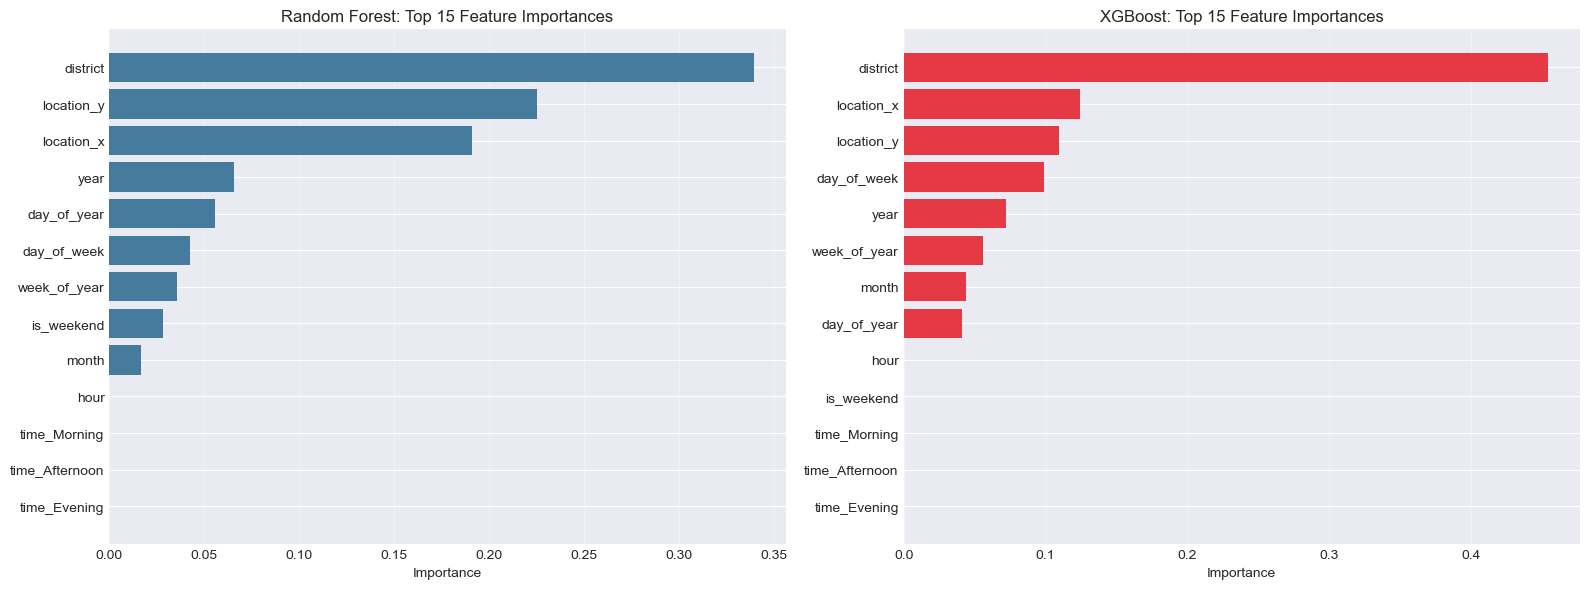

✓ Feature importance visualization saved


In [12]:
# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest importance
axes[0].barh(range(len(rf_importance)), rf_importance['importance'], color='#457B9D')
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest: Top 15 Feature Importances')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost importance
axes[1].barh(range(len(xgb_importance)), xgb_importance['importance'], color='#E63946')
axes[1].set_yticks(range(len(xgb_importance)))
axes[1].set_yticklabels(xgb_importance['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost: Top 15 Feature Importances')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / '04_classification_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature importance visualization saved")

## 8. SHAP Analysis for Interpretability

Use SHAP values to understand model decisions (using XGBoost model).

In [13]:
# Compute SHAP values for a sample of test data
print("Computing SHAP values (this may take a minute)...")

# Sample 500 instances for SHAP analysis (to speed up computation)
X_test_sample = X_test.sample(min(500, len(X_test)), random_state=RANDOM_SEED)

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_sample)

print("✓ SHAP values computed")

Computing SHAP values (this may take a minute)...
✓ SHAP values computed


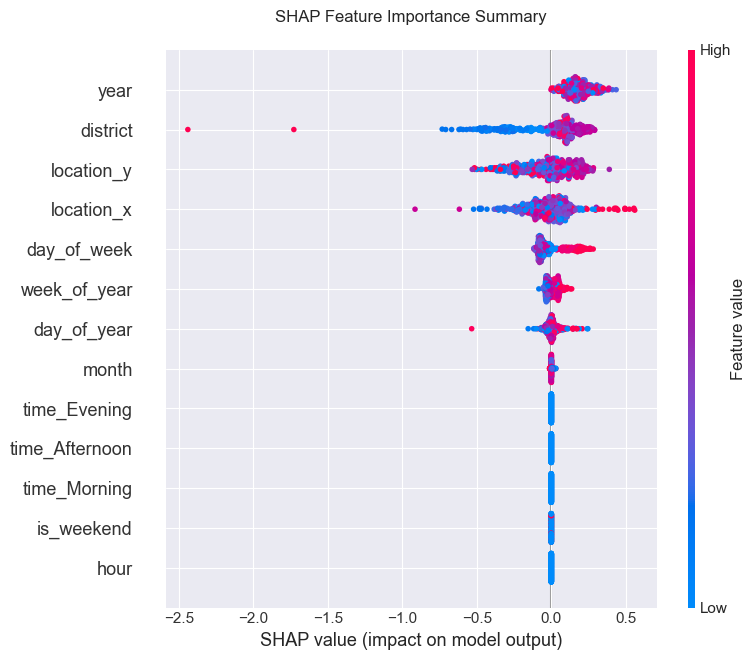

✓ SHAP summary visualization saved


In [14]:
# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('SHAP Feature Importance Summary', pad=20)
plt.tight_layout()
plt.savefig(REPORTS_DIR / '04_classification_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP summary visualization saved")

## 9. Performance Visualizations

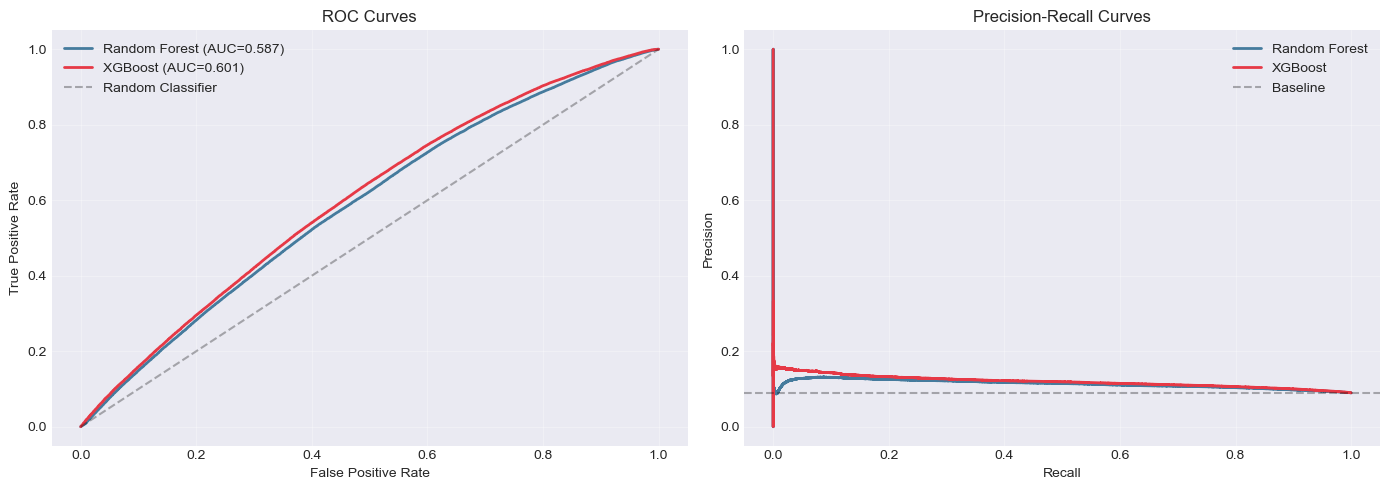

✓ Performance curves saved


In [15]:
# ROC curves and Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DEFENSIVE: Ensure y_test is clean for curves
if len(y_test) > 1000000:
    y_test = pd.Series(y_test.astype(int).values[:len(X_test)], index=X_test.index, dtype=int)

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test.values, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test.values, y_prob_xgb)

axes[0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_metrics["roc_auc"]:.3f})', linewidth=2, color='#457B9D')
axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_metrics["roc_auc"]:.3f})', linewidth=2, color='#E63946')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test.values, y_prob_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test.values, y_prob_xgb)

axes[1].plot(recall_rf, precision_rf, label='Random Forest', linewidth=2, color='#457B9D')
axes[1].plot(recall_xgb, precision_xgb, label='XGBoost', linewidth=2, color='#E63946')
axes[1].axhline(y_test.values.mean(), color='k', linestyle='--', alpha=0.3, label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / '04_classification_performance_curves.png', dpi=300, bbox_inches='tight')
plt.savefig(REPORTS_DIR / '04_classification_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Performance curves saved")

## 10. Model Card: Documentation and Limitations

Create comprehensive model documentation including performance metrics and known limitations.

In [16]:
# Create model cards for both models
rf_card = create_model_card(
    model_name="Violence Classification - Random Forest",
    model_type="RandomForestClassifier",
    features=X_train.columns.tolist(),
    train_metrics={
        "accuracy": rf_model.score(rf_scaler.transform(X_train) if rf_scaler else X_train, y_train),
    },
    test_metrics={
        "accuracy": rf_metrics['classification_report']['accuracy'],
        "roc_auc": rf_metrics['roc_auc'],
        "precision_violent": rf_metrics['classification_report']['Violent']['precision'],
        "recall_violent": rf_metrics['classification_report']['Violent']['recall'],
        "f1_violent": rf_metrics['classification_report']['Violent']['f1-score'],
    },
    limitations=[
        "Model trained on historical data; performance may degrade with changing crime patterns",
        f"Class imbalance: {(1-y.mean())*100:.1f}% non-violent vs {y.mean()*100:.1f}% violent",
        "Temporal features may not capture sudden policy changes or external events",
        "Limited to features available at time of dispatch (no investigation outcomes)",
        "Geographic coverage limited to Philadelphia; not generalizable to other cities",
        "Model should be retrained periodically as new data becomes available",
    ]
)

xgb_card = create_model_card(
    model_name="Violence Classification - XGBoost",
    model_type="XGBClassifier",
    features=X_train.columns.tolist(),
    train_metrics={
        "accuracy": xgb_model.score(X_train, y_train),
    },
    test_metrics={
        "accuracy": xgb_metrics['classification_report']['accuracy'],
        "roc_auc": xgb_metrics['roc_auc'],
        "precision_violent": xgb_metrics['classification_report']['Violent']['precision'],
        "recall_violent": xgb_metrics['classification_report']['Violent']['recall'],
        "f1_violent": xgb_metrics['classification_report']['Violent']['f1-score'],
    },
    limitations=[
        "Model trained on historical data; performance may degrade with changing crime patterns",
        f"Class imbalance: {(1-y.mean())*100:.1f}% non-violent vs {y.mean()*100:.1f}% violent",
        "Temporal features may not capture sudden policy changes or external events",
        "Limited to features available at time of dispatch (no investigation outcomes)",
        "Geographic coverage limited to Philadelphia; not generalizable to other cities",
        "Model should be retrained periodically as new data becomes available",
    ]
)

print("Model Cards Created\n")
print("="*80)
print("RANDOM FOREST MODEL CARD")
print("="*80)
print(f"Model: {rf_card['model_name']}")
print(f"Type: {rf_card['model_type']}")
print(f"Features: {rf_card['n_features']}")
print(f"\nTest Performance:")
for metric, value in rf_card['test_performance'].items():
    print(f"  {metric}: {value:.4f}")
print(f"\nLimitations:")
for i, limitation in enumerate(rf_card['limitations'], 1):
    print(f"  {i}. {limitation}")

print("\n" + "="*80)
print("XGBOOST MODEL CARD")
print("="*80)
print(f"Model: {xgb_card['model_name']}")
print(f"Type: {xgb_card['model_type']}")
print(f"Features: {xgb_card['n_features']}")
print(f"\nTest Performance:")
for metric, value in xgb_card['test_performance'].items():
    print(f"  {metric}: {value:.4f}")
print(f"\nLimitations:")
for i, limitation in enumerate(xgb_card['limitations'], 1):
    print(f"  {i}. {limitation}")

Model Cards Created

RANDOM FOREST MODEL CARD
Model: Violence Classification - Random Forest
Type: RandomForestClassifier
Features: 13

Test Performance:
  accuracy: 0.9104
  roc_auc: 0.5872
  precision_violent: 0.0000
  recall_violent: 0.0000
  f1_violent: 0.0000

Limitations:
  1. Model trained on historical data; performance may degrade with changing crime patterns
  2. Class imbalance: 90.5% non-violent vs 9.5% violent
  3. Temporal features may not capture sudden policy changes or external events
  4. Limited to features available at time of dispatch (no investigation outcomes)
  5. Geographic coverage limited to Philadelphia; not generalizable to other cities
  6. Model should be retrained periodically as new data becomes available

XGBOOST MODEL CARD
Model: Violence Classification - XGBoost
Type: XGBClassifier
Features: 13

Test Performance:
  accuracy: 0.9104
  roc_auc: 0.6014
  precision_violent: 0.0000
  recall_violent: 0.0000
  f1_violent: 0.0000

Limitations:
  1. Model tra

In [17]:
# Save model cards to JSON
import json

with open(REPORTS_DIR / '04_classification_rf_model_card.json', 'w') as f:
    json.dump(rf_card, f, indent=2)

with open(REPORTS_DIR / '04_classification_xgb_model_card.json', 'w') as f:
    json.dump(xgb_card, f, indent=2)

print("✓ Model cards saved to reports directory")

✓ Model cards saved to reports directory


In [18]:
# Export consolidated performance metrics to CSV (FORECAST-02 artifact)
results = [
    {"model": "Random Forest", "metric": "accuracy", "value": float(rf_metrics['classification_report']['accuracy']), "description": "Overall accuracy"},
    {"model": "Random Forest", "metric": "precision_violent", "value": float(rf_metrics['classification_report']['Violent']['precision']), "description": "Precision for violent class"},
    {"model": "Random Forest", "metric": "recall_violent", "value": float(rf_metrics['classification_report']['Violent']['recall']), "description": "Recall for violent class"},
    {"model": "Random Forest", "metric": "f1_violent", "value": float(rf_metrics['classification_report']['Violent']['f1-score']), "description": "F1-score for violent class"},
    {"model": "Random Forest", "metric": "auc_roc", "value": float(rf_metrics['roc_auc']), "description": "Area under ROC curve"},
    {"model": "Random Forest", "metric": "precision_nonviolent", "value": float(rf_metrics['classification_report']['Non-Violent']['precision']), "description": "Precision for non-violent class"},
    {"model": "Random Forest", "metric": "recall_nonviolent", "value": float(rf_metrics['classification_report']['Non-Violent']['recall']), "description": "Recall for non-violent class"},
    {"model": "XGBoost", "metric": "accuracy", "value": float(xgb_metrics['classification_report']['accuracy']), "description": "Overall accuracy"},
    {"model": "XGBoost", "metric": "precision_violent", "value": float(xgb_metrics['classification_report']['Violent']['precision']), "description": "Precision for violent class"},
    {"model": "XGBoost", "metric": "recall_violent", "value": float(xgb_metrics['classification_report']['Violent']['recall']), "description": "Recall for violent class"},
    {"model": "XGBoost", "metric": "f1_violent", "value": float(xgb_metrics['classification_report']['Violent']['f1-score']), "description": "F1-score for violent class"},
    {"model": "XGBoost", "metric": "auc_roc", "value": float(xgb_metrics['roc_auc']), "description": "Area under ROC curve"},
    {"model": "XGBoost", "metric": "precision_nonviolent", "value": float(xgb_metrics['classification_report']['Non-Violent']['precision']), "description": "Precision for non-violent class"},
    {"model": "XGBoost", "metric": "recall_nonviolent", "value": float(xgb_metrics['classification_report']['Non-Violent']['recall']), "description": "Recall for non-violent class"},
    {"model": "Meta", "metric": "class_imbalance", "value": float(y.mean()), "description": "Violent crime percentage"},
    {"model": "Meta", "metric": "random_seed", "value": float(RANDOM_SEED), "description": "Reproducibility seed"},
    {"model": "Meta", "metric": "test_size", "value": 0.2, "description": "Test set fraction"},
    {"model": "Meta", "metric": "n_features", "value": float(X.shape[1]), "description": "Number of features used"},
]
pd.DataFrame(results).to_csv(REPORTS_DIR / 'classification_model_performance.csv', index=False)
print("✓ Performance metrics exported to reports/classification_model_performance.csv")


✓ Performance metrics exported to reports/classification_model_performance.csv


## 11. Summary and Recommendations

Key findings and operational recommendations for resource allocation.

In [19]:
# Generate summary report
summary = f"""
VIOLENCE CLASSIFICATION MODEL SUMMARY
{'='*80}

OBJECTIVE:
  Predict whether crime incidents are violent vs non-violent to support
  resource allocation and operational planning.

DATA:
  Total incidents: {len(df):,}
  Date range: {df['dispatch_date'].min()} to {df['dispatch_date'].max()}
  Violent incidents: {y.sum():,} ({y.mean()*100:.2f}%)
  Non-violent incidents: {(~y.astype(bool)).sum():,} ({(1-y.mean())*100:.2f}%)

METHODOLOGY:
  - Time-aware train/test split (80/20) - no shuffling to prevent data leakage
  - Training period: {X_train.index.min()} to {X_train.index.max()}
  - Testing period: {X_test.index.min()} to {X_test.index.max()}
  - Random seed: {RANDOM_SEED} (for reproducibility)

MODELS TRAINED:
  1. Random Forest (n_estimators=200, max_depth=10)
  2. XGBoost (n_estimators=200, max_depth=6, lr=0.1)

PERFORMANCE (Test Set):
  Random Forest:
    - ROC-AUC: {rf_metrics['roc_auc']:.4f}
    - Accuracy: {rf_metrics['classification_report']['accuracy']:.4f}
    - Violent Precision: {rf_metrics['classification_report']['Violent']['precision']:.4f}
    - Violent Recall: {rf_metrics['classification_report']['Violent']['recall']:.4f}
    - Violent F1: {rf_metrics['classification_report']['Violent']['f1-score']:.4f}

  XGBoost:
    - ROC-AUC: {xgb_metrics['roc_auc']:.4f}
    - Accuracy: {xgb_metrics['classification_report']['accuracy']:.4f}
    - Violent Precision: {xgb_metrics['classification_report']['Violent']['precision']:.4f}
    - Violent Recall: {xgb_metrics['classification_report']['Violent']['recall']:.4f}
    - Violent F1: {xgb_metrics['classification_report']['Violent']['f1-score']:.4f}

TOP 5 PREDICTIVE FEATURES:
  Random Forest:
{chr(10).join([f'    {i+1}. {row["feature"]}: {row["importance"]:.4f}' for i, row in rf_importance.head(5).iterrows()])}

  XGBoost:
{chr(10).join([f'    {i+1}. {row["feature"]}: {row["importance"]:.4f}' for i, row in xgb_importance.head(5).iterrows()])}

KEY LIMITATIONS:
  - Class imbalance may affect minority class predictions
  - Model performance depends on stable crime patterns
  - Limited to features available at dispatch time
  - Requires periodic retraining with new data

OPERATIONAL RECOMMENDATIONS:
  1. Use model predictions to prioritize violent incident response
  2. Monitor model performance monthly; retrain quarterly
  3. Combine predictions with officer judgment for final decisions
  4. Track false positives/negatives to identify improvement areas
  5. Consider ensemble of both models for robust predictions

ARTIFACTS GENERATED:
  - reports/04_classification_class_distribution.png
  - reports/04_classification_feature_importance.png
  - reports/04_classification_shap_summary.png
  - reports/04_classification_performance_curves.png
  - reports/04_classification_rf_model_card.json
  - reports/04_classification_xgb_model_card.json

{'='*80}
"""

print(summary)

# Save summary to file
with open(REPORTS_DIR / '04_classification_summary.txt', 'w') as f:
    f.write(summary)

print("✓ Summary report saved")


VIOLENCE CLASSIFICATION MODEL SUMMARY

OBJECTIVE:
  Predict whether crime incidents are violent vs non-violent to support
  resource allocation and operational planning.

DATA:
  Total incidents: 3,496,353
  Date range: 2006-01-01 00:00:00 to 2026-01-20 00:00:00
  Violent incidents: 333,298 (9.53%)
  Non-violent incidents: 3,163,055 (90.47%)

METHODOLOGY:
  - Time-aware train/test split (80/20) - no shuffling to prevent data leakage
  - Training period: 2006-01-01 00:00:00 to 2021-08-04 00:00:00
  - Testing period: 2021-08-04 00:00:00 to 2026-01-20 00:00:00
  - Random seed: 42 (for reproducibility)

MODELS TRAINED:
  1. Random Forest (n_estimators=200, max_depth=10)
  2. XGBoost (n_estimators=200, max_depth=6, lr=0.1)

PERFORMANCE (Test Set):
  Random Forest:
    - ROC-AUC: 0.5872
    - Accuracy: 0.9104
    - Violent Precision: 0.0000
    - Violent Recall: 0.0000
    - Violent F1: 0.0000

  XGBoost:
    - ROC-AUC: 0.6014
    - Accuracy: 0.9104
    - Violent Precision: 0.0000
    - Vio

## Reproducibility Cell

This notebook can be re-run end-to-end to reproduce all results.

In [20]:
# Environment information for reproducibility
import sys
print("Python version:", sys.version)
print("\nKey package versions:")
import pandas, numpy, sklearn, xgboost, shap, matplotlib, seaborn
print(f"  pandas: {pandas.__version__}")
print(f"  numpy: {numpy.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")
print(f"  xgboost: {xgboost.__version__}")
print(f"  shap: {shap.__version__}")
print(f"  matplotlib: {matplotlib.__version__}")
print(f"  seaborn: {seaborn.__version__}")
print(f"\nRandom seed: {RANDOM_SEED}")
print(f"\nAll results are reproducible by re-running this notebook with the same seed.")

Python version: 3.14.2 | packaged by Anaconda, Inc. | (main, Dec 19 2025, 11:42:52) [Clang 20.1.8 ]

Key package versions:
  pandas: 2.3.3
  numpy: 2.4.1
  scikit-learn: 1.8.0
  xgboost: 3.1.3
  shap: 0.50.0
  matplotlib: 3.10.8
  seaborn: 0.13.2

Random seed: 42

All results are reproducible by re-running this notebook with the same seed.
